# Making noise with EEG
Plays frequencies according to the sum of EEG signals at a certain time.

By default the raw EEG music is commented out - running this notebook will play the mean EEG signal per second!

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyaudio

In [247]:
df = pd.read_csv('blinks.csv') 

df['Index'] = df.index

In [248]:
df["EXG Sum"] = df[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', 
                    ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', 
                    ' EXG Channel 6', ' EXG Channel 7']].sum(axis=1)
print(df.columns)
print(df['EXG Sum'])
df = df.iloc[5:]

Index(['Sample Index', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2',
       ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6',
       ' EXG Channel 7', ' Accel Channel 0', ' Accel Channel 1',
       ' Accel Channel 2', ' Other', ' Other.1', ' Other.2', ' Other.3',
       ' Other.4', ' Other.5', ' Other.6', ' Analog Channel 0',
       ' Analog Channel 1', ' Analog Channel 2', ' Timestamp', ' Other.7',
       ' Timestamp (Formatted)', 'Index', 'EXG Sum'],
      dtype='object')
0        112023.411634
1        107528.140548
2        109378.574416
3        113203.471983
4             0.000000
             ...      
32161    127563.931354
32162    130868.726178
32163    132418.976118
32164    129092.433046
32165    127147.384244
Name: EXG Sum, Length: 32166, dtype: float64


# Basic data visualization for one channel
Change the following cell to select a channel

In [249]:
selected_channel = ' EXG Channel 1'
# selected_channel = 'EXG Sum'

In [250]:
exg_min = df[selected_channel].min()
exg_max = df[selected_channel].max()
exg_range = exg_max - exg_min

print(f"Range: {exg_range} (Min: {exg_min}, Max: {exg_max})")


Range: 13759.085686097827 (Min: 31585.60771770569, Max: 45344.69340380352)


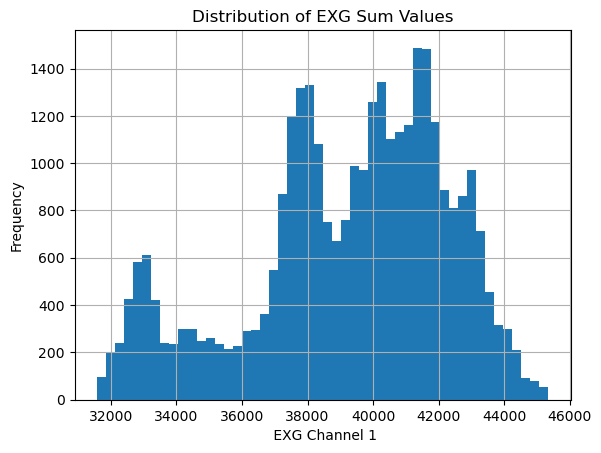

In [251]:
df[selected_channel].hist(bins=50)  # Adjust bins as needed
plt.xlabel(selected_channel)
plt.ylabel("Frequency")
plt.title("Distribution of EXG Sum Values")
plt.show()


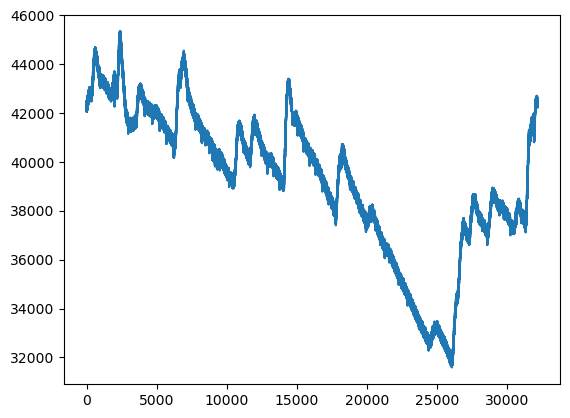

In [252]:
# view raw data
start = 5 # ignore noise at the beginning

x = np.array(df['Index'][start:])
y = np.array(df[selected_channel][start:])

plt.plot(x,y)
plt.show()

# Function to play music based on sum of EEG signals
Displays the normalized frequency list and a graph adjusted for frequency so you can follow the tones.

The duration parameter is the length in seconds a tone is played.

In [253]:
def play(df=df, duration=0.05):
    # Normalize sum to frequency range (200 Hz to 1000 Hz)
    min_exg, max_exg = df[selected_channel].min(), df[selected_channel].max()
    df["Frequency"] = 200 + (df[selected_channel] - min_exg) / (max_exg - min_exg) * (600-offset - 200-offset)
    print(df['Frequency'])
    df['Index'] = df.index

    start = 5 # ignore noise at the beginning

    x = np.array(df['Index'][start:])
    y = np.array(df['Frequency'][start:])

    plt.plot(x,y)
    plt.show()

    # Audio settings
    RATE = 44100  # Sample rate
    DURATION = duration  # Duration per sound in seconds
    CHUNK = 1024  # Audio chunk size

    # Initialize PyAudio
    p = pyaudio.PyAudio()

    # Function to generate a sine wave
    def generate_sine_wave(frequency, duration, rate):
        t = np.linspace(0, duration, int(rate * duration), endpoint=False)
        wave = (np.sin(2 * np.pi * frequency * t) * 0.5).astype(np.float32)  # Normalize amplitude
        return wave.tobytes()

    # Stream audio for each row in the dataframe
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, output=True)

    for freq in df["Frequency"]:
        wave_data = generate_sine_wave(freq, DURATION, RATE)
        stream.write(wave_data)

    # Stop stream
    stream.stop_stream()
    stream.close()
    p.terminate()


In [254]:
# play(df, duration=0.003) # plays raw EEG data

# Adjust for the mean of each second
Calculate the mean frequency per channel at every second, then play EEG sum as normal

In [255]:

# Convert Timestamp (Formatted) to datetime for easier processing
df[' Timestamp (Formatted)'] = pd.to_datetime(df[' Timestamp (Formatted)'])

# Extract the second part of the timestamp
df['Timestamp_Second'] = df[' Timestamp (Formatted)'].dt.floor('S')

# Group by the Timestamp (ignoring the milliseconds) and calculate the mean of each column
df_grouped = df.groupby('Timestamp_Second').mean().reset_index()

# Drop the non-relevant columns for clarity (if you need them)
# df_grouped.drop(['Timestamp', 'Other'], axis=1, inplace=True)

# Show the result
print(df_grouped)

       Timestamp_Second  Sample Index   EXG Channel 0   EXG Channel 1  \
0   2025-01-22 03:38:55     57.500000    33861.229213    42403.642241   
1   2025-01-22 03:38:56    127.808765    34714.742676    42754.048925   
2   2025-01-22 03:38:57    128.004000    36332.550237    43689.023607   
3   2025-01-22 03:38:58    128.273092    35798.129326    44122.892923   
4   2025-01-22 03:38:59    128.167331    34221.029864    43397.171572   
..                  ...           ...             ...             ...   
125 2025-01-22 03:41:00    126.996000    34130.438492    37614.720507   
126 2025-01-22 03:41:01    127.140000    36416.731735    40015.240373   
127 2025-01-22 03:41:02    127.284000    35750.338078    41472.108122   
128 2025-01-22 03:41:03    127.430279    35078.318022    41978.901114   
129 2025-01-22 03:41:04    145.000000    34805.597315    42448.869802   

      EXG Channel 2   EXG Channel 3   EXG Channel 4   EXG Channel 5  \
0      -7043.625627    22405.639217        187500.0 

/var/folders/kl/mf67c0m52sn81pgn606s8rh40000gn/T/ipykernel_17541/2491069480.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['Timestamp_Second'] = df[' Timestamp (Formatted)'].dt.floor('S')


In [256]:
df_grouped["EXG Sum"] = df[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', 
                    ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', 
                    ' EXG Channel 6', ' EXG Channel 7']].sum(axis=1)
print(df_grouped.columns)
print(df_grouped['EXG Sum'])

Index(['Timestamp_Second', 'Sample Index', ' EXG Channel 0', ' EXG Channel 1',
       ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5',
       ' EXG Channel 6', ' EXG Channel 7', ' Accel Channel 0',
       ' Accel Channel 1', ' Accel Channel 2', ' Other', ' Other.1',
       ' Other.2', ' Other.3', ' Other.4', ' Other.5', ' Other.6',
       ' Analog Channel 0', ' Analog Channel 1', ' Analog Channel 2',
       ' Timestamp', ' Other.7', ' Timestamp (Formatted)', 'Index', 'EXG Sum'],
      dtype='object')
0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
125    35504.203797
126    35082.627545
127    37226.562169
128    37795.481121
129    35529.483620
Name: EXG Sum, Length: 130, dtype: float64


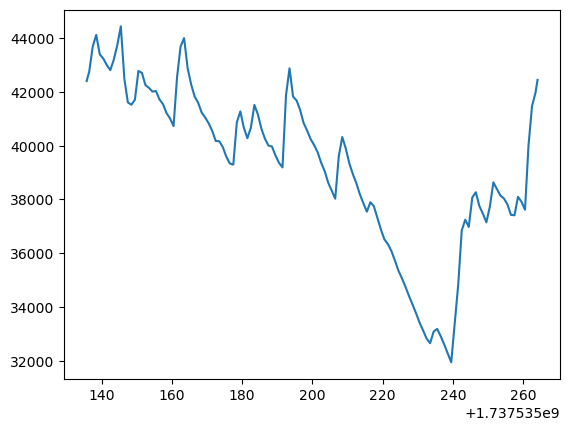

In [257]:
start = 0 # ignore noise at the beginning

x = np.array(df_grouped[' Timestamp'][start:])
y = np.array(df_grouped[selected_channel][start:])

plt.plot(x,y)
plt.show()

0      534.823702
1      546.033056
2      575.942479
3      589.821765
4      566.606262
          ...    
125    381.628232
126    458.419792
127    505.024341
128    521.236423
129    536.270512
Name: Frequency, Length: 130, dtype: float64


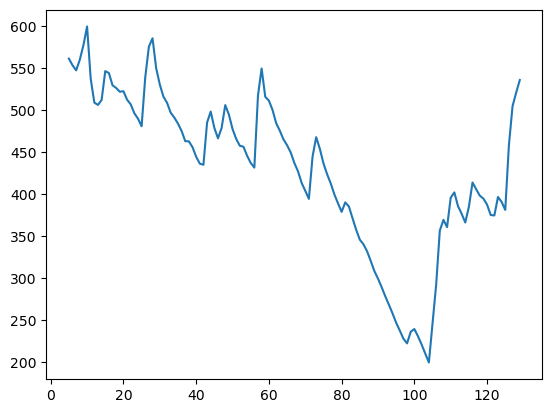

In [261]:
play(df_grouped, duration=0.1)